# Health Insurance Lead Prediction - Classification Model

### Project Background / Objective
Upon visiting an insurance company's website, a policy is recommended to the person and that person becomes 'Lead' or potential customer for the company. Goal of this model is to predict whether or not this potential customer will eventually become an actual customer. Since I know how to develop a classification model with supervised learning, I will also be testing a few different types of algorithm such as KNN, SVM, Decision Tree, Random Forest and AdaBoost, compare their cross-validated evaluation score, tune their hyperparameter when necessary and ultimately pick the best performing model to deploy.

### Conceptual Problems

Before we begin, I want to address a few conceptual problems as to why these algorithms (especially those using bagging and boosting method) are used in this project.
1. What is bagging and how does it work ?
- According to [Wikipedia Source](https://en.wikipedia.org/wiki/Bootstrap_aggregating), Bagging or Bootstrap Aggregating is a concept developed by Leo Breiman in 1994 to improve classification by combining classifications of randomly generated training sets.
- The idea of bagging is to train multiple models on different subsets of the original dataset, then combine their predictions to get the final prediction.
2. What's the difference between Random Forest and XGBoost ?
- Random Forest is a popular bagging method based on Decision Trees. It works just like bagging method mentioned earlier: first it uses bootstrap sampling to create multiple subsets of the original dataset. For each bootstrap sample, a decision tree is constructed and trained. Then each decision tree predicts outcome for given input. In classification task, the final prediction is determined by majority voting.
- Meanwhile, AdaBoost is ensemble learning method with boosting. The idea of boosting is to sequentially train weak learner to learn from it's past mistake so it's performance will get better with more sequence.
3. What is cross-validation ?
- When training a model, changes in train data would also affect the model's performance. Some algorithms are more stable than the other but ultimately they will still get affected. Cross-validation is a technique used to assess model's stability by repeatedly train the model on different subsets of train data and evaluate their performance. We can then compare said model's average performance and standar deviation. The average score shows how reliable is the model's performance while the standard deviation shows it's stability when facing unseen data.

# Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

import pickle

# Data Loading

In [2]:
data = pd.read_csv("Health Insurance Lead Prediction Raw Data.csv")
data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


Data loaded successfully
- We can see some missing values already and '+' in columns that are supposed to be numerical.

In [3]:
data.Holding_Policy_Type.unique()

array([ 3., nan,  1.,  4.,  2.])

### Column Understanding

- `ID`: Lead's ID
- `City_Code`: Lead's City Code
- `Region_Code`: Lead's Region Code
- `Accomodation_Type`: Lead's accomodation type (Rented/Owned)
- `Reco_Insurance_Type`: Recommended Insurance Type (Individual/Joint)
- `Upper_Age`: For individual type, the lead's age. For joint type, the age of the oldest member in the group
- `Lower_Age`: For individual type, the lead's age. For joint type, the age of the youngest member in the group
- `Is_Spouse`: Lead's marital status
- `Health Indicator`: Code indicating the lead's health condition
- `Holding_Policy_Duration`: Length of time that the lead has been engaged or in contact with the company
- `Holding_Policy_Type`: Policy type in encoded form
- `Reco_Policy_Cat`: Recommended policy category in encoded form
- `Reco_Policy_Premium`: Calculated premium cost for insurance coverage
- `Response`: 1: Lead become actual customer; 0: Other outcome

## Data Cleaning

**Copy Data**

In [4]:
data_clean = data.copy()

**Data Info**

In [5]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

**Changing Data Type**

In [6]:
data_clean.Holding_Policy_Duration.unique()

array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

We will remove '+' and change the datatype to numeric

In [7]:
data_clean['Holding_Policy_Duration'] = data_clean['Holding_Policy_Duration'].str.replace('+', '')
data_clean['Holding_Policy_Duration'] = data_clean['Holding_Policy_Duration'].apply(pd.to_numeric)
data_clean.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration    float64
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
dtype: object

Data type successfully changed

# Exploratory Data Analysis

**Copy Data**

In [8]:
data_eda = data_clean.copy()

**Data Info**

In [9]:
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  float64
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(3), int64(6

- 50882 rows data
- 3 float columns
- 6 int columns
- 5 object columns

### Check Target's Balance

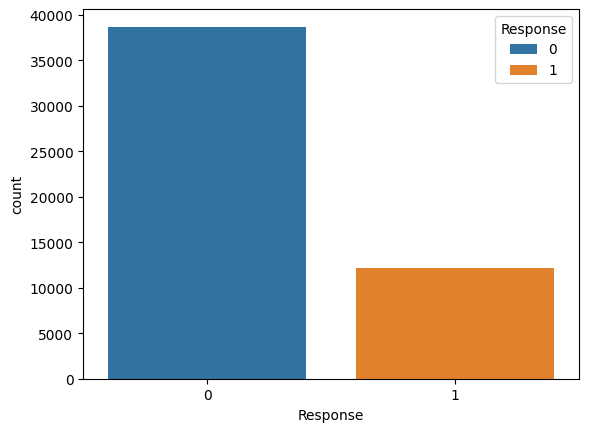

Response
0    38673
1    12209
Name: count, dtype: int64

In [10]:
sns.barplot(x=data_eda['Response'].value_counts().index, y=data_eda['Response'].value_counts(), hue=data_eda['Response'].value_counts().index)
plt.show()
data_eda['Response'].value_counts()

Over 25000 difference in count. Data Balancing might be needed.

### Check Missing Values

In [11]:
(data_eda.isna().sum() / len(data_eda)) * 100

ID                          0.000000
City_Code                   0.000000
Region_Code                 0.000000
Accomodation_Type           0.000000
Reco_Insurance_Type         0.000000
Upper_Age                   0.000000
Lower_Age                   0.000000
Is_Spouse                   0.000000
Health Indicator           22.976691
Holding_Policy_Duration    39.799929
Holding_Policy_Type        39.799929
Reco_Policy_Cat             0.000000
Reco_Policy_Premium         0.000000
Response                    0.000000
dtype: float64

In [12]:
len(data_eda[(data_eda['Health Indicator'].isna()) | (data_eda['Holding_Policy_Duration'].isna()) | (data_eda['Holding_Policy_Type'].isna())]) / len(data_eda) * 100

53.72037262686216

We have quite a significant amount of missing values in health indicator, holding policy duration and holding policy type. 53% of total rows data have missing values.

*Health Indicator*

In [13]:
data_eda[(data_eda['Health Indicator'].isna())]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
6,7,C3,679,Owned,Individual,28,28,No,NaN,NaN,NaN,17,10640.0,0
9,10,C1,530,Owned,Joint,59,26,Yes,NaN,7.0,4.0,18,21100.8,1
12,13,C7,3453,Owned,Individual,66,66,No,NaN,1.0,2.0,20,17192.0,1
19,20,C20,973,Owned,Individual,27,27,No,NaN,NaN,NaN,4,8050.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50859,50860,C1,217,Owned,Individual,70,70,No,NaN,6.0,3.0,20,19448.0,0
50865,50866,C21,4915,Owned,Individual,74,74,No,NaN,NaN,NaN,14,19944.0,0
50869,50870,C11,1770,Rented,Individual,45,45,No,NaN,1.0,1.0,20,10944.0,0
50871,50872,C10,224,Rented,Individual,21,21,No,NaN,1.0,1.0,13,11840.0,0


There seems to be quite a lot of rows with missing values in health indicator that also has 0 response. Let us check.

In [14]:
data_eda[(data_eda['Health Indicator'].isna()) & (data_eda['Response'] == 0)]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
6,7,C3,679,Owned,Individual,28,28,No,NaN,NaN,NaN,17,10640.0,0
19,20,C20,973,Owned,Individual,27,27,No,NaN,NaN,NaN,4,8050.0,0
34,35,C9,518,Rented,Individual,22,22,No,NaN,NaN,NaN,11,5950.0,0
35,36,C10,1410,Owned,Individual,56,56,No,NaN,NaN,NaN,18,13574.0,0
40,41,C2,1036,Owned,Individual,64,64,No,NaN,14.0,3.0,3,19830.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50859,50860,C1,217,Owned,Individual,70,70,No,NaN,6.0,3.0,20,19448.0,0
50865,50866,C21,4915,Owned,Individual,74,74,No,NaN,NaN,NaN,14,19944.0,0
50869,50870,C11,1770,Rented,Individual,45,45,No,NaN,1.0,1.0,20,10944.0,0
50871,50872,C10,224,Rented,Individual,21,21,No,NaN,1.0,1.0,13,11840.0,0


8953 rows. Our Response column is imbalanced with too many '0' values. Rather than filling the gap by oversampling with synthetic data, I think it's more reasonable to undersample by dropping these columns instead since they have missing values anyway. The rest we will impute with the column's mode.

In [15]:
data_eda = data_eda[(data_eda['Health Indicator'].isna() == False) | (data_eda['Response'] != 0)]
data_eda

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14.0,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14.0,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,C4,845,Rented,Individual,22,22,No,X3,NaN,NaN,18,7704.0,0
50878,50879,C5,4188,Rented,Individual,27,27,No,X3,7.0,3.0,4,5408.0,0
50879,50880,C1,442,Rented,Individual,63,63,No,X2,14.0,1.0,12,11374.0,0
50880,50881,C1,4,Owned,Joint,71,49,No,X2,2.0,2.0,16,28179.2,1


8953 rows dropped.

*Holding Policy Duration & Holding Policy Type*

I suspect values in both holding policy duration and holding policy type always missing together. Let's check.

In [16]:
data_eda[(data_eda['Holding_Policy_Duration'].isna() == False) & (data_eda['Holding_Policy_Type'].isna())]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response


My suspicion was right. Their values always missing together.

In [17]:
data_eda[data_eda['Holding_Policy_Duration'].isna()]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
10,11,C28,600,Owned,Individual,21,21,No,X2,NaN,NaN,21,4068.0,1
13,14,C5,900,Rented,Individual,20,20,No,X2,NaN,NaN,18,8364.0,0
15,16,C3,1484,Rented,Individual,20,20,No,X3,NaN,NaN,2,4912.0,0
17,18,C7,677,Owned,Individual,43,43,No,X2,NaN,NaN,19,10386.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50862,50863,C8,558,Owned,Individual,23,23,No,X2,NaN,NaN,17,6110.0,0
50863,50864,C1,3705,Owned,Individual,75,75,No,X3,NaN,NaN,16,17850.0,1
50864,50865,C27,3469,Owned,Individual,72,72,No,X4,NaN,NaN,2,17312.0,0
50867,50868,C6,2040,Owned,Individual,37,37,No,X2,NaN,NaN,20,10016.0,0


Just like before, let's check how many rows with missing values has '0' values in response column.

In [18]:
data_eda[(data_eda['Holding_Policy_Duration'].isna()) & (data_eda['Response'] == 0)]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
13,14,C5,900,Rented,Individual,20,20,No,X2,NaN,NaN,18,8364.0,0
15,16,C3,1484,Rented,Individual,20,20,No,X3,NaN,NaN,2,4912.0,0
17,18,C7,677,Owned,Individual,43,43,No,X2,NaN,NaN,19,10386.0,0
21,22,C24,1127,Rented,Individual,23,23,No,X2,NaN,NaN,16,10352.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50861,50862,C7,3677,Rented,Individual,20,20,No,X4,NaN,NaN,19,5832.0,0
50862,50863,C8,558,Owned,Individual,23,23,No,X2,NaN,NaN,17,6110.0,0
50864,50865,C27,3469,Owned,Individual,72,72,No,X4,NaN,NaN,2,17312.0,0
50867,50868,C6,2040,Owned,Individual,37,37,No,X2,NaN,NaN,20,10016.0,0


11872 rows. Again, just like before let's drop these rows. We will then figure out how to handle the rest of the missing values. This will make the response column more balanced.

In [19]:
data_eda = data_eda[(data_eda['Holding_Policy_Duration'].isna() == False) | (data_eda['Response'] != 0)]
data_eda

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14.0,3.0,22,11628.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14.0,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0
5,6,C9,1785,Rented,Individual,52,52,No,X2,5.0,1.0,22,15264.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50875,50876,C6,231,Rented,Individual,36,36,No,X3,2.0,1.0,20,13574.0,1
50878,50879,C5,4188,Rented,Individual,27,27,No,X3,7.0,3.0,4,5408.0,0
50879,50880,C1,442,Rented,Individual,63,63,No,X2,14.0,1.0,12,11374.0,0
50880,50881,C1,4,Owned,Joint,71,49,No,X2,2.0,2.0,16,28179.2,1


11872 rows dropped.

Now let's try and figure out how to impute the rest of the missing values

In [20]:
data_eda[data_eda['Holding_Policy_Duration'].isna()]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
10,11,C28,600,Owned,Individual,21,21,No,X2,NaN,NaN,21,4068.0,1
27,28,C9,855,Rented,Individual,21,21,No,X5,NaN,NaN,16,3744.0,1
56,57,C2,1876,Owned,Individual,65,65,No,X4,NaN,NaN,3,20520.0,1
64,65,C25,2200,Rented,Individual,20,20,No,X1,NaN,NaN,21,6850.0,1
67,68,C2,1742,Owned,Individual,69,69,No,X4,NaN,NaN,3,16104.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50770,50771,C19,1835,Owned,Individual,38,38,No,NaN,NaN,NaN,19,11232.0,1
50775,50776,C2,1804,Rented,Individual,47,47,No,NaN,NaN,NaN,22,10656.0,1
50826,50827,C2,2018,Owned,Individual,47,47,No,X4,NaN,NaN,21,13000.0,1
50854,50855,C6,1594,Rented,Individual,20,20,No,X2,NaN,NaN,15,8456.0,1


There doesn't seem to be any recognizable pattern we can use to reasonably impute with. So we choose the safest imputation method: mean for numerical feature and mode for categorical feature.

### Check Duplicates

In [21]:
data_eda.duplicated().sum()

0

No duplicate rows

### Check Outliers

The only numerical features we have are lower/upper age, policy duration and policy premium. Lower/upper age might have outliers but they shouldn't be a problem considering their max range not even 100. Policy duration is already capped with lower limit 1 and upper limit 14. So all that's left to check is the policy premium.

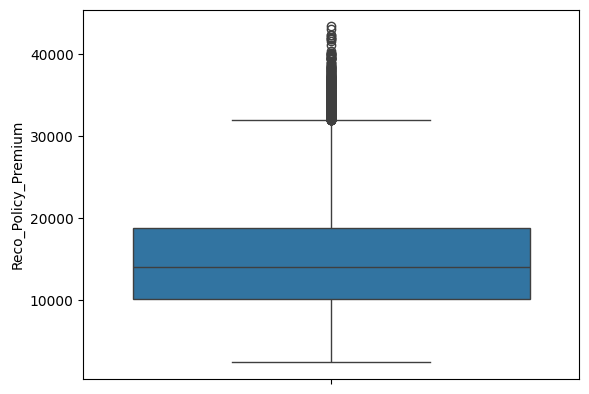

In [22]:
sns.boxplot(data=data_eda['Reco_Policy_Premium'])
plt.show()

It seems the most extreme outlier is about 10000 difference from the upper limit. There shouldn't be a problem to use capping method in this case because the value difference is not too extreme.

**Save Data**

In [57]:
data_eda.to_csv('data_eda.csv')

### Data Distribution

**Upper/Lower Age**

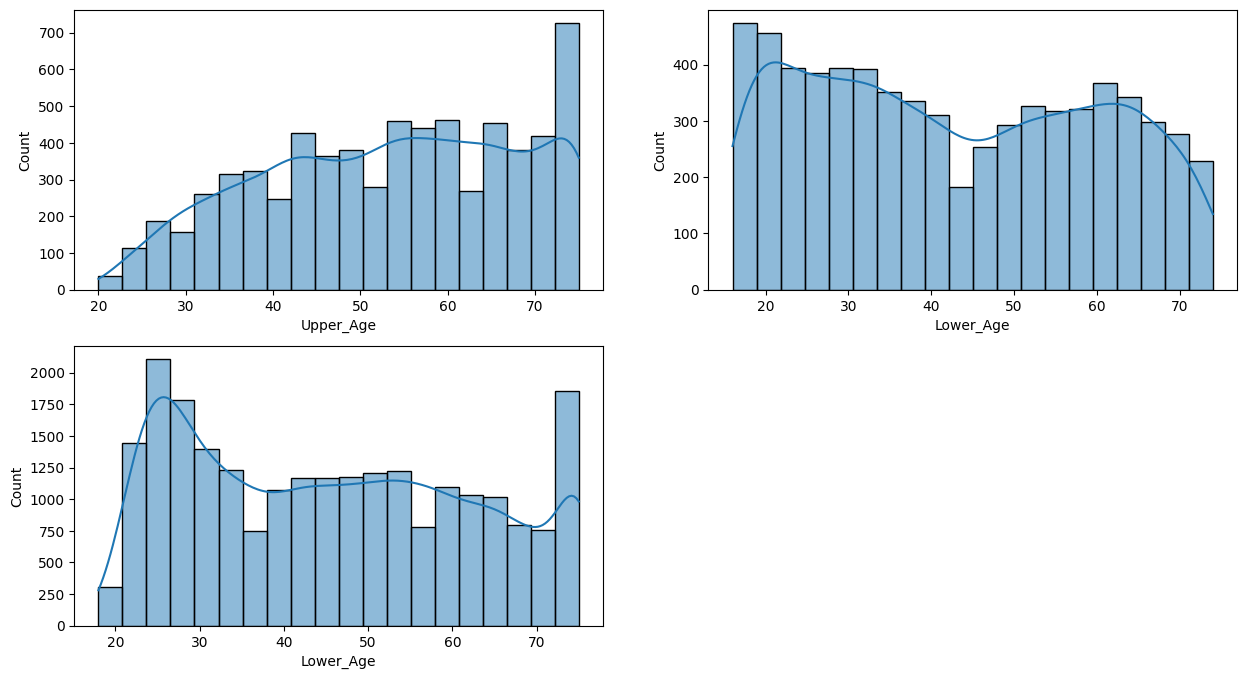

Upper age (Joint) skewness: -0.2119888116955597
Lower age (Joint) skewness: 0.1351411753387297
Individual age skewness: 0.21541363271663658


In [23]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
sns.histplot(data_eda['Upper_Age'][data_eda['Reco_Insurance_Type']=='Joint'], kde=True, bins=20)

plt.subplot(2,2,2)
sns.histplot(data_eda['Lower_Age'][data_eda['Reco_Insurance_Type']=='Joint'], kde=True, bins=20)

plt.subplot(2,2,3)
sns.histplot(data_eda['Lower_Age'][data_eda['Reco_Insurance_Type']=='Individual'], kde=True, bins=20)

plt.show()

print(f'Upper age (Joint) skewness: {data_eda["Upper_Age"][data_eda["Reco_Insurance_Type"]=="Joint"].skew()}')
print(f'Lower age (Joint) skewness: {data_eda["Lower_Age"][data_eda["Reco_Insurance_Type"]=="Joint"].skew()}')
print(f'Individual age skewness: {data_eda["Lower_Age"][data_eda["Reco_Insurance_Type"]=="Individual"].skew()}')

The age columns are normally distributed

**Binary Valued Columns**

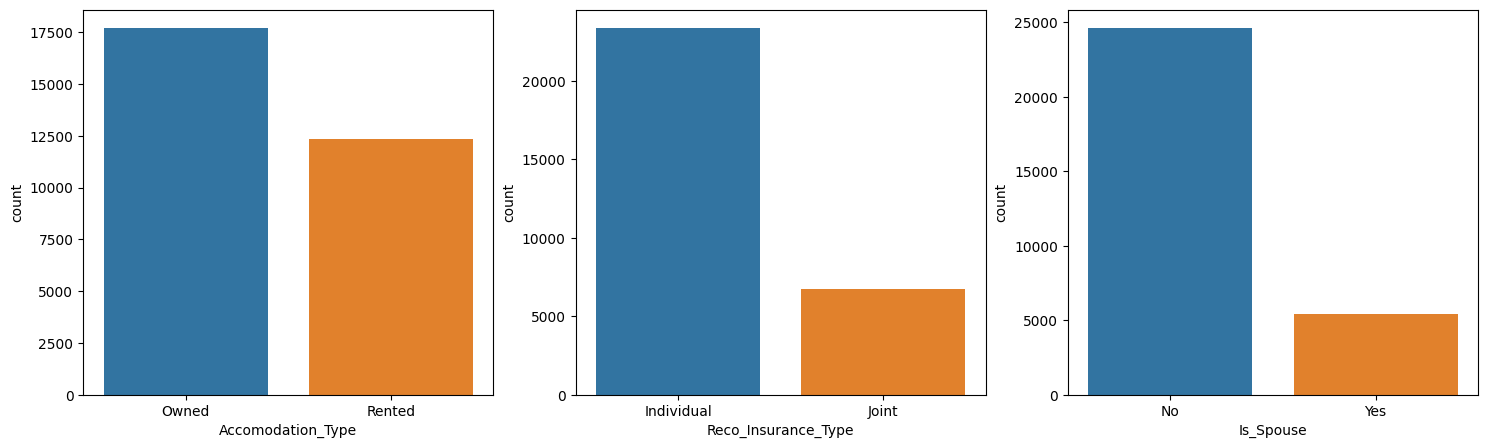

In [24]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.barplot(x=data_eda['Accomodation_Type'].value_counts().index, y=data_eda['Accomodation_Type'].value_counts(), hue=data_eda['Accomodation_Type'].value_counts().index)

plt.subplot(1,3,2)
sns.barplot(x=data_eda['Reco_Insurance_Type'].value_counts().index, y=data_eda['Reco_Insurance_Type'].value_counts(), hue=data_eda['Reco_Insurance_Type'].value_counts().index)

plt.subplot(1,3,3)
sns.barplot(x=data_eda['Is_Spouse'].value_counts().index, y=data_eda['Is_Spouse'].value_counts(), hue=data_eda['Is_Spouse'].value_counts().index)

plt.show()

Most leads are not married, are recommended individual type insurance and although the proportion seems balanced, there are more leads who own their living space than renting them.

**Response Balance Check**

As we have dropped some columns (while checking for missing values), let's take another look at our response variable's balance

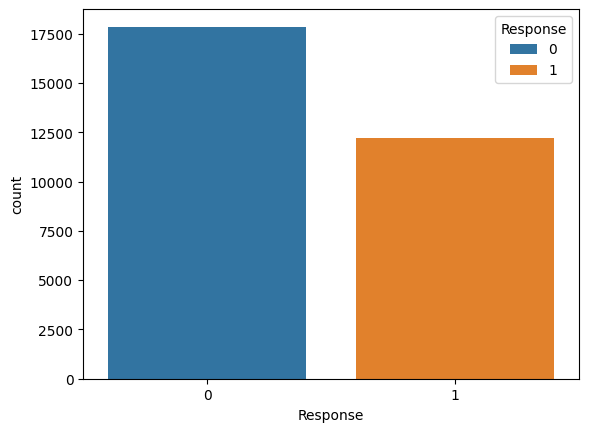

Response
0    17848
1    12209
Name: count, dtype: int64

In [25]:
sns.barplot(x=data_eda['Response'].value_counts().index, y=data_eda['Response'].value_counts(), hue=data_eda['Response'].value_counts().index)
plt.show()
data_eda['Response'].value_counts()

They look more balanced now, further balancing may not be needed.

# Feature Engineering

**Copy Data**

In [26]:
data_fe = data_eda.copy()

### Data Splitting

In [27]:
X=data_fe.drop(columns=['ID', 'Response'])
y=data_fe['Response']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Selection

**Correlation Test with Kendall** <br>
Kendall's Tau method is very versatile and can capture relationship between continuous, ordinal or nominal data. For this reason, we will use this method to check the correlation between features and response

In [29]:
# initialize empty lists
coeff = []

for col in data_fe.columns:
    # Perform Kendall tau test
    kendalltau_corr, p_value = stats.kendalltau(data_fe[col][(data_fe['Health Indicator'].isna() == False) & (data_fe['Holding_Policy_Duration'].isna() == False)], data_fe.Response[(data_fe['Health Indicator'].isna() == False) & (data_fe['Holding_Policy_Duration'].isna() == False)])
    # append to list
    coeff.append(kendalltau_corr)

# store data in dataframe
df_corr = pd.DataFrame({
    'column': data_fe.columns,
    'correlation_coefficients': coeff
})
df_corr

,column,correlation_coefficients
0,ID,0.003501
1,City_Code,-0.001692
2,Region_Code,0.002050
3,Accomodation_Type,-0.001946
4,Reco_Insurance_Type,0.008537
5,Upper_Age,-0.003886
6,Lower_Age,-0.008050
7,Is_Spouse,0.002365
8,Health Indicator,-0.007364
9,Holding_Policy_Duration,0.020399


Most of the features don't seem to have corelation with the response. With threshold of 0.01, Holding policy duration and reco policy cat have the most impact on whether or not the lead will become actual customer. I'll also add holding policy type to list of selected features as it's quite close to the threshold of 0.01. The rest will be dropped.

In [30]:
X_train.drop(columns=['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Reco_Policy_Premium'], inplace=True)
X_test.drop(columns=['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Reco_Policy_Premium'], inplace=True)
X_train

,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat
10800,5.0,3.0,8
50101,4.0,1.0,16
39114,6.0,4.0,21
22204,NaN,NaN,15
17591,2.0,1.0,21
...,...,...,...
50460,1.0,2.0,20
9224,14.0,1.0,16
1497,2.0,1.0,18
26977,2.0,2.0,17


Columns successfully dropped

### Preprocessing

- We will impute the missing values with the strategy we talked above.
- We will scale using RobustScaler. It's a generally good scaler method to use.
- Holding Policy Type is encoded already but since they're low cardinality anyway let's apply one hot encoder
- Reco Policy Cat is encoded and has high cardinality, so we won't do one hot encoder on it and just let it passthrough

In [31]:
num_col = ['Holding_Policy_Duration']
ohe_col = ['Holding_Policy_Type', 'Reco_Policy_Cat']

In [32]:
numerical = Pipeline(steps=[
    ('impute:mean', SimpleImputer(strategy='mean')),
    ('scale', RobustScaler())
])

cat_ohe = Pipeline(steps=[
    ('impute:mode', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical, num_col),
    ('ohe', cat_ohe, ohe_col)
])

preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('impute:mean',
                                                  SimpleImputer()),
                                                 ('scale', RobustScaler())]),
                                 ['Holding_Policy_Duration']),
                                ('ohe',
                                 Pipeline(steps=[('impute:mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe', OneHotEncoder())]),
                                 ['Holding_Policy_Type', 'Reco_Policy_Cat'])])

Our pipelined preprocessor is ready. Time to train our model.

# Model Training (Base)

**KNN**

In [33]:
# define
knn_base = Pipeline(
    steps=[("preprocessor", preprocessor), ("knn", KNeighborsClassifier())]
)
# train
knn_base.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute:mean',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['Holding_Policy_Duration']),
                                                 ('ohe',
                                                  Pipeline(steps=[('impute:mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Holding_Policy_Type',
                                                   'Reco_Policy_Cat'])])),
                ('knn', KNeighborsClassifier())])

**SVC**

In [34]:
# define
svc_base = Pipeline(
    steps=[("preprocessor", preprocessor), ("svc", SVC(random_state=10))]
)
# train
svc_base.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute:mean',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['Holding_Policy_Duration']),
                                                 ('ohe',
                                                  Pipeline(steps=[('impute:mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Holding_Policy_Type',
                                                   'Reco_Policy_Cat'])])),
                ('svc', SVC(random_state=10))])

**Decision Tree**

In [35]:
# define
dt_base = Pipeline(
    steps=[("preprocessor", preprocessor), ("dt", DecisionTreeClassifier(random_state=10))]
)
# train
dt_base.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute:mean',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['Holding_Policy_Duration']),
                                                 ('ohe',
                                                  Pipeline(steps=[('impute:mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Holding_Policy_Type',
                                                   'Reco_Policy_Cat'])])),
                ('dt', DecisionTreeClassifier(random_state=10))])

**Random Forest**

In [36]:
# define
rf_base = Pipeline(
    steps=[("preprocessor", preprocessor), ("rf", RandomForestClassifier(random_state=10))]
)
# train
rf_base.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute:mean',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['Holding_Policy_Duration']),
                                                 ('ohe',
                                                  Pipeline(steps=[('impute:mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Holding_Policy_Type',
                                                   'Reco_Policy_Cat'])])),
                ('rf', RandomForestClassifier(random_state=10))])

**AdaBoost**

In [37]:
# define
ada_base = Pipeline(
    steps=[("preprocessor", preprocessor), ("ada", AdaBoostClassifier(random_state=10))]
)
# train
ada_base.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute:mean',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['Holding_Policy_Duration']),
                                                 ('ohe',
                                                  Pipeline(steps=[('impute:mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Holding_Policy_Type',
                                                   'Reco_Policy_Cat'])])),
                ('ada', AdaBoostClassifier(random_state=10))])

### Cross Validation

Now is a good time to talk about the evaluation metrics we will be using. Since the goal set by the company for me is to predict which lead will become actual customer, I can safely assume their priority right now is to be able to target leads with highest potential to become their customer, therefore we will use precision metric to evaluate our model because we want to minimize false positive predictions.

**KNN**

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and evaluate the model
cv_scores = cross_val_score(knn_base, X_train, y_train, cv=kf, scoring='precision')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

# Print the mean and standard deviation
print("Mean Cross-Validation Score:", mean_cv_score)
print("Standard Deviation of Cross-Validation Scores:", std_cv_score)

Mean Cross-Validation Score: 0.7114536832456404
Standard Deviation of Cross-Validation Scores: 0.004717730473932585


**SVC**

In [39]:
# Perform cross-validation and evaluate the model
cv_scores = cross_val_score(svc_base, X_train, y_train, cv=kf, scoring='precision')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

# Print the mean and standard deviation
print("Mean Cross-Validation Score:", mean_cv_score)
print("Standard Deviation of Cross-Validation Scores:", std_cv_score)

Mean Cross-Validation Score: 0.6964765263067856
Standard Deviation of Cross-Validation Scores: 0.005892134054484522


**Decision Tree**

In [40]:
# Perform cross-validation and evaluate the model
cv_scores = cross_val_score(dt_base, X_train, y_train, cv=kf, scoring='precision')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

# Print the mean and standard deviation
print("Mean Cross-Validation Score:", mean_cv_score)
print("Standard Deviation of Cross-Validation Scores:", std_cv_score)

Mean Cross-Validation Score: 0.8499274607532337
Standard Deviation of Cross-Validation Scores: 0.008627791887762977


**Random Forest**

In [41]:
# Perform cross-validation and evaluate the model
cv_scores = cross_val_score(rf_base, X_train, y_train, cv=kf, scoring='precision')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

# Print the mean and standard deviation
print("Mean Cross-Validation Score:", mean_cv_score)
print("Standard Deviation of Cross-Validation Scores:", std_cv_score)

Mean Cross-Validation Score: 0.8318857982999484
Standard Deviation of Cross-Validation Scores: 0.005775698735736184


**AdaBoost**

In [42]:
# Perform cross-validation and evaluate the model
cv_scores = cross_val_score(ada_base, X_train, y_train, cv=kf, scoring='precision')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

# Print the mean and standard deviation
print("Mean Cross-Validation Score:", mean_cv_score)
print("Standard Deviation of Cross-Validation Scores:", std_cv_score)

Mean Cross-Validation Score: 0.9525441027747485
Standard Deviation of Cross-Validation Scores: 0.006210415988880053


#### Which model performs the best ?

Hmm there's actually quite a big gap between AdaBoost, and AdaBoost obviously performs better here. So, we will go with AdaBoost this time. Let's try to do hyperparameter tuning to see if we can further improve its performance.

### \#\#\# Hyperparameter Tuning skipped due to time-constraint \#\#\#
The following code will be commented out of our code as it takes up too much time (even with randomized search). Since the base model performs rather well already, we will continue with base model for now. We will come back if we have the time to manually do the tuning and compare the result.

### Hyperparameter Tuning

SVC's algorithm is quite complex and takes quite a while to compute. If we use gridsearch to tune it's hyperparameter it will take too long. So with this consideration, we will go with faster but less accurate route: randomized search.

In [46]:
# define parameter
ada_params = {'ada__n_estimators': [50, 100, 200], 'ada__learning_rate': [0.2, 0.5, 1.0]}

In [44]:
# ada_tune = RandomizedSearchCV(estimator=ada_base, param_distributions=ada_params, cv=5, scoring='precision')
# ada_tune.fit(X_train, y_train)

# ada_best = ada_tune.best_estimator_   # get best performing model

# # print best parameters found
# print("Best Parameters:", ada_tune.best_params_)

# # print best score found
# print("Best Score:", ada_tune.best_score_)

# Model Evaluation

In [47]:
def display_report(model, X_train, y_train, X_test, y_test):
    y_pred_test = model.predict(X_test)
    final_report = classification_report(y_test, y_pred_test)
    print("Final Classification Report on Test Set:")
    print(final_report)
    return

In [50]:
print('Base Logistic Regression')
display_report(ada_base, X_train, y_train, X_test, y_test)

Base Logistic Regression
Final Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.70      0.99      0.82      3519
           1       0.96      0.40      0.56      2493

    accuracy                           0.74      6012
   macro avg       0.83      0.69      0.69      6012
weighted avg       0.81      0.74      0.71      6012



The result shows that although our desired metrics reach a high score but the model's recall metric is still quite low. This may well be potential future improvement.

# Model Saving

Let's save this model to do inference and deployment

In [55]:
with open('model.pkl', 'wb') as file_1:
    pickle.dump(ada_base, file_1)

# Conclusion

*Model Analysis* <br>
- Boosting method appear to outperform other algorithm for our case.
- The model's recall is still quite low -> idea for future improvement
- hyperparameter tuning might help increase the score and solve this problem -> idea for future improvement
- 95% precision metric is nothing to scoff at, that roughly means if our agent focuses on leads that's predicted to convert, they have 95% success rate
<br><br>

*Overall Analysis* <br>
- Data is initially imbalanced and only through somewhat forced balancing method later appear to be acceptably balanced
- Data has too many missing values with unknown causes (close to or more than 50% of total data) -> regather data with improved system to prevent missing entry
- We got rid of many unrelated features that might confuse the model with their low corelativity